In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import totalsedimentload as tsl
from read_korean_data import *
from py_sedyield import *
#from matplotlib.patches import Polygon
import matplotlib.ticker as ticker
import re
import matplotlib.lines as mlines
import scipy.stats as sp
import matplotlib
%matplotlib inline

In [2]:
#plt.rc('font', family='Helvetica')
plt.rc("xtick",labelsize="large")
plt.rc("ytick",labelsize="large")
plt.rc("axes", labelsize="large")
plt.rc('axes', axisbelow=True)

In [3]:
paths  = findExcelFiles()

stations = {}

for path in paths:
    i = path.rfind("/")
    j = path.find("_", i)
    k = path.find("_", j+1)
    f = path[j+1:k]

    df = read_dischargeTimeSeries(path)
    sed = read_sediment_measurement(path)
    sed = sed[['Date', 'Q', 'C']]
    sed[['Q', 'C']] = sed[['Q', 'C']].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    sed = sed.dropna(subset=["C"])
    stations[f] = {'dailyQ': df, 'measureC': sed}

In [4]:
for path in paths:
    i = path.rfind("/")
    j = path.find("_", i)
    k = path.find("_", j+1)
    f = path[j+1:k]

    df = tsl.raw_extract(path)
    semep = tsl.semep_procedure(df)
    Q = semep.Q
    Qt = semep.Qt
    q_qt_relation = trainLinear(Q, Qt)
    df['site'] = f
    
    stations[f].update({"fdc": flowDuration(stations[f]['dailyQ']),"src": q_qt_relation,
                        "semep":semep})

C:\Users\cyyang\Dropbox\work\dissertation\totalsedimentload.py:126: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  ,names=["Date", "A", "h", "Q", "Temp", "C", "d50", "d65", "dss", "S"])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [5]:
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Rectangle

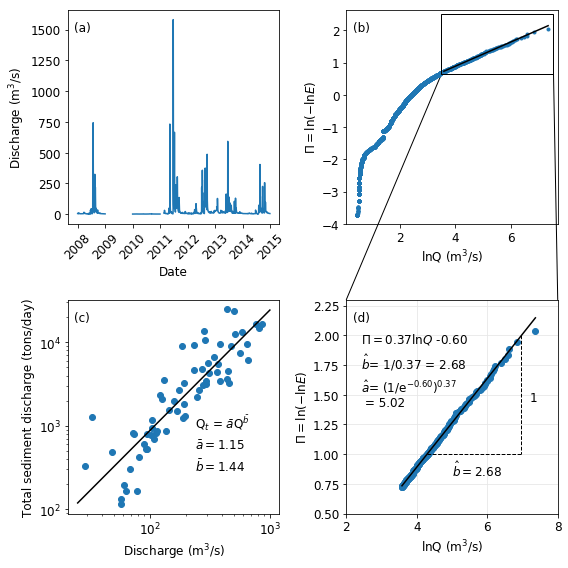

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8,8))

site = 'N9'

ax1.plot(stations[site]['dailyQ']['date'], stations[site]['dailyQ']['Q'])
ax1.set_ylabel('Discharge (m$^3$/s)')
ax1.set_xlabel('Date')
ax1.xaxis.set_tick_params(rotation=45)


ax2.plot(np.log(stations[site]['fdc'].Q), np.log(-np.log(stations[site]['fdc']["P"]/100)), '.')

df = stations[site]['fdc']

df = df[df['Q'] > 1.5*df['Q'].mean()]
x = df["Q"]
y = -np.log(df["P"]/100)


x = np.log(x)
x = sm.add_constant(x)
ols = sm.OLS(np.log(y), x).fit()

(a, b) = (ols.params[0], ols.params[1])

ax4.plot(x.Q, np.log(y), 'o')
ax4.plot(x.Q, a + x.Q * b, 'k-')
ax2.plot(x.Q, a + x.Q * b, 'k-')

ax4.set_ylim((0.5,2.3))
ax4.set_xlim((2,8))
ax2.set_ylim(ymin=-4)

ax2.set_ylabel(r'$\Pi = \ln(-\ln E)$')



ax3.plot(stations[site]['semep']['Q'], stations[site]['semep']['Qt'], 'o')
ax3.set(xscale='log', yscale='log', xlabel='Discharge (m$^3$/s)', ylabel='Total sediment discharge (tons/day)')
ax1.annotate('(a)', (0.03,0.9), xycoords='axes fraction', fontsize='large')
ax2.annotate('(b)', (0.03,0.9), xycoords='axes fraction', fontsize='large')
ax3.annotate('(c)', (0.03,0.9), xycoords='axes fraction', fontsize='large')
ax4.annotate('(d)', (0.03,0.9), xycoords='axes fraction', fontsize='large')



abar, bbar = np.e**stations[site]['src'].params[0], stations[site]['src'].params[1] 
_x = np.linspace(25, 1000, 10)
ax3.plot(_x, abar*_x**bbar, 'k-')
ax3.annotate(r'Q$_t$ = $\bar{a}$Q$^{\bar{b}}$', xy=(0.6, 0.4), xycoords="axes fraction", fontsize='large')
ax3.annotate(r'$\bar{a} = 1.15$', xy=(0.6, 0.3), xycoords="axes fraction", fontsize='large')
ax3.annotate(r'$\bar{b} = 1.44$', xy=(0.6, 0.2), xycoords="axes fraction", fontsize='large')

con1 = ConnectionPatch(xyA=(0.98, 0.7), xyB=(8,2.3), coordsA="axes fraction", coordsB="data", arrowstyle="-",
                      axesA=ax2, axesB=ax4)

con2 = ConnectionPatch(xyA=(0.45, 0.7), xyB=(2,2.3), coordsA="axes fraction", coordsB="data", arrowstyle="-",
                      axesA=ax2, axesB=ax4)
ax2.add_artist(con1)
ax2.add_artist(con2)
ax4.set_zorder(-1)

fig.patches.extend([plt.Rectangle((0.45,0.7),0.53,0.28,
                                  fill=False, zorder=1000,
                                  transform=ax2.transAxes, figure=fig)])
ax4.annotate(r"$\Pi=$" + "{:.{prec}f}".format(b, prec=2) + r"$\ln Q $ {:.{prec}f}".format(a, prec=2),
             xy=(0.07,0.8), xycoords="axes fraction", fontsize="large")


ax4.annotate(r"$\hat{b}$" + "= 1/0.37 = {:.{prec}f}".format(1/b, prec=2), xy=(0.07,0.68), xycoords="axes fraction", fontsize="large")
ax4.annotate(r"$\hat{a}$" + r"= (1/e$^{-0.60})^{0.37}$" + "\n = {:.{prec}f}".format((1/np.e**a)**(1/b), prec=2), xy=(0.07,0.5), xycoords="axes fraction", fontsize="large")

ax4.annotate("1", xy=(7.2,1.45), fontsize="large")
ax4.annotate(r"$\hat{b} = 2.68$", xy=(5,0.82), fontsize="large")
ax4.plot([(2-a)/b, (2-a)/b], [2, 1], 'k--', linewidth=1)
ax4.plot([(1-a)/b, (2-a)/b], [1, 1], 'k--', linewidth=1)
ax4.grid(color='0.9')

ax2.set_xlabel(r"$\ln$Q (m$^3$/s)")
ax4.set_xlabel(r"$\ln$Q (m$^3$/s)")
ax4.set_ylabel(r'$\Pi = \ln(-\ln E)$')
fig.tight_layout()
fig.savefig('./chapter 6/N9.pdf', format='pdf', dpi=500, transparent = True, bbox_inches = 'tight', pad_inches = 0)

a = 0.55, b = 0.37
ahat = 5.02, bhat = 2.68


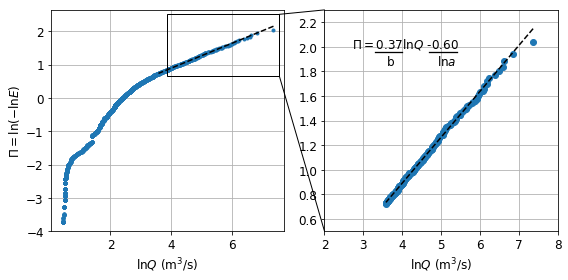

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

df = stations[site]['fdc']

ax1.plot(np.log(df.Q), np.log(-np.log(df["P"]/100)), '.')



ax1.grid(which='both')

#ax1.set_xlim((1,10))



df = df[df['Q'] > 1.5*df['Q'].mean()]
x = df["Q"]
y = -np.log(df["P"]/100)


x = np.log(x)
x = sm.add_constant(x)
ols = sm.OLS(np.log(y), x).fit()

(a, b) = (ols.params[0], ols.params[1])

ax2.plot(x.Q, np.log(y), 'o')
ax2.plot(x.Q, a + x.Q * b, 'k--')
ax1.plot(x.Q, a + x.Q * b, 'k--')

ax2.set_ylim((0.5,2.3))
ax2.set_xlim((2,8))
ax1.set_ylim(ymin=-4)
ax2.grid(which='both')
ax1.set_ylabel(r'$\Pi = \ln(-\ln E)$')
for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\ln Q$ (m$^3$/s)')


con1 = ConnectionPatch(xyA=(0.98, 0.7), xyB=(2,0.5), coordsA="axes fraction", coordsB="data", arrowstyle="-",
                      axesA=ax1, axesB=ax2)

con2 = ConnectionPatch(xyA=(0.98, 0.98), xyB=(2,2.3), coordsA="axes fraction", coordsB="data", arrowstyle="-",
                      axesA=ax1, axesB=ax2)
ax1.add_artist(con1)
ax1.add_artist(con2)
ax2.set_zorder(-1)

fig.patches.extend([plt.Rectangle((0.5,0.7),0.48,0.28,
                                  fill=False, zorder=1000,
                                  transform=ax1.transAxes, figure=fig)])


ax2.plot([3.3, 4], [1.96, 1.96], 'k-', lw=1.3)
ax2.plot([4.7, 5.4], [1.96, 1.96], 'k-', lw=1.3)
ax2.annotate('b', (3.6, 1.85), fontsize='large')
ax2.annotate('$\ln a$', (4.9, 1.85), fontsize='large')
ax2.annotate(r"$\Pi=$" + "{:.{prec}f}".format(b, prec=2) + r"$\ln Q $ {:.{prec}f}".format(a, prec=2),
             xy=(0.12,0.83), xycoords="axes fraction", fontsize="large")

fig.tight_layout()
a = np.e**a
#fig.savefig("./chapter 6/c6fig1.pdf", format='pdf', dpi=500, bbox_inches='tight')

print('a = {:.{prec}f}'.format(a, prec=2) + ', b = {:.{prec}f}'.format(b, prec=2))
print('ahat = {:.{prec}f}'.format((1/a) **(1/b), prec=2) + ', bhat = {:.{prec}f}'.format(1/b, prec=2))

ahat = 5.02, bhat = 2.68
abar = 1.15, bbar = 1.44


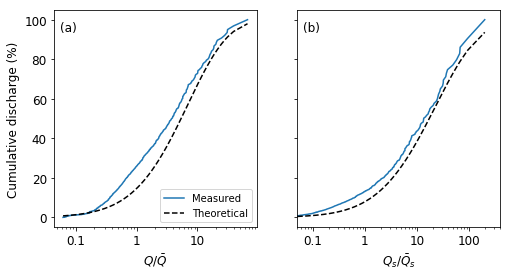

In [8]:
df = stations[site]['dailyQ']
df = df.dropna()


 
sort = df.sort_values(by='Q')
Q = sort['Q']
Qcf = sort['Q'].cumsum() / sort['Q'].sum()
Qmean = sort['Q'].mean()
    
Qs = abar * Q**bbar
Qscf = Qs.cumsum() / Qs.sum()
Qsmean = Qs.mean()

i = a * Q **b
ahat = (1/a) **(1/b)
bhat = (1/b)
P1 = sp.gamma.cdf(i, bhat + 1)
P2 = sp.gamma.cdf(i, bhat * bbar + 1)
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4), sharey=True)

ax1.plot(Q/Qmean, Qcf*100, label='Measured')
ax1.plot(Q/Qmean, P1*100, 'k--', label='Theoretical')
ax1.set_xscale('log')

ax2.plot(Qs/Qsmean, Qscf*100)
ax2.plot(Qs/Qsmean, P2*100, 'k--')
ax2.set_xscale('log')
ax2.set_xlim(0.05, 400)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))

ax1.annotate('(a)', (0.03,0.9), xycoords='axes fraction', fontsize='large')
ax2.annotate('(b)', (0.03,0.9), xycoords='axes fraction', fontsize='large')
ax1.set_ylabel('Cumulative discharge (%)')
ax1.set_xlabel(r'$Q/\bar{Q}$')
ax2.set_xlabel(r'$Q_s/\bar{Q}_s$')
ax1.legend(loc=4)
print('ahat = {:.{prec}f}'.format(ahat, prec=2) + ', bhat = {:.{prec}f}'.format(bhat, prec=2))
print('abar = {:.{prec}f}'.format(abar, prec=2) + ', bbar = {:.{prec}f}'.format(bbar, prec=2))

#fig.savefig('./chapter 6/c6fig3.pdf', format='pdf', dpi=500, bbox_inches='tight')

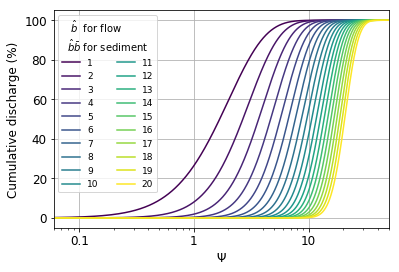

In [9]:
bhat = np.arange(1, 21, 1)
i = np.linspace(0.06, 50, 10000)


start = 0.0
stop = 1.0
number_of_lines= len(bhat)
cm_subsection = np.linspace(start, stop, number_of_lines) 

colors = [ matplotlib.cm.viridis(x) for x in cm_subsection ]


fig, ax = plt.subplots(figsize=(6,4))

for b, color in zip(bhat, colors):
    P = sp.gamma.cdf(i, b + 1)
    ax.plot(i, P * 100, label=str(b), color=color)
    
ax.set_xscale('log')
ax.margins(x=0)
ax.set_xlabel(r'$\Psi$')
ax.set_ylabel('Cumulative discharge (%)')
ax.legend(title=r" $\hat{b}$  for flow"
          "\n" 
          r"$\hat{b}\bar{b}$ for sediment", ncol=2, fontsize=9)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
ax.grid()
fig.savefig('./chapter 6/c6fig2.pdf', format='pdf', dpi=500, bbox_inches='tight')

In [10]:
site = 'N9'
df = stations[site]['dailyQ']

def solve_a_b(x):
    from scipy.optimize import fsolve
    from scipy.special import gamma
    mean = x.mean()
    sm   = (x**2).mean()
    print('Qmean = {:.{prec}f}'.format(mean, prec=2) + ', Qvar = {:.{prec}f}'.format(sm, prec=2))
    def b_func(b):
        return (sm/mean**2) - gamma(1 + 2/b)/gamma(1 + 1/b)**2
    b = fsolve(b_func, 0.1)
    a = (gamma(1 + 1/b)/mean)**b
    return a[0], b[0]


am, bm = solve_a_b(df['Q'].dropna())
ahatm = (1/am) **(1/bm)
bhatm = (1/bm)

print('a = {:.{prec}f}'.format(am, prec=2) + ', b = {:.{prec}f}'.format(bm, prec=2))
print('ahat = {:.{prec}f}'.format(ahatm, prec=2) + ', bhat = {:.{prec}f}'.format(bhatm, prec=2))

Qmean = 23.71, Qvar = 5111.61
a = 0.41, b = 0.43
ahat = 8.37, bhat = 2.35


0.11970042328056588 0.07096189637390393 1.0232912837576646 5.658986998559422


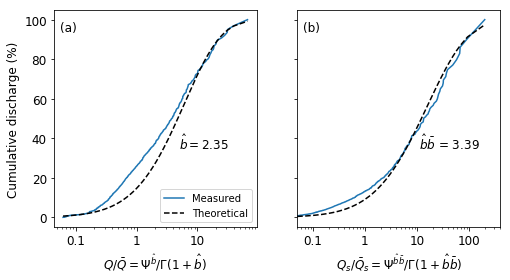

In [11]:


abar, bbar = np.e**stations[site]['src'].params[0], stations[site]['src'].params[1] 
df = stations[site]['dailyQ']
df = df.dropna()
df = df[df['Q'] > 0]


sort = df.sort_values(by='Q')
Q = sort['Q']

Qcf = sort['Q'].cumsum() / sort['Q'].sum()
Qmean = sort['Q'].mean()
normQ = Q/Qmean

Qs = abar * Q**bbar
Qscf = Qs.cumsum() / Qs.sum()
Qsmean = Qs.mean()
normQs = Qs/Qsmean
i = am * Q **bm

P1 = sp.gamma.cdf(i, bhatm + 1)
P2 = sp.gamma.cdf(i, bhatm * bbar + 1)
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4), sharey=True)

ax1.plot(Q/Qmean, Qcf*100, label='Measured')
ax1.plot(Q/Qmean, P1*100, 'k--', label='Theoretical')
ax1.set_xscale('log')

ax2.plot(Qs/Qsmean, Qscf*100)
ax2.plot(Qs/Qsmean, P2*100, 'k--')
ax2.set_xscale('log')
ax2.set_xlim(0.05, 400)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))

ax1.annotate('(a)', (0.03,0.9), xycoords='axes fraction', fontsize='large')
ax2.annotate('(b)', (0.03,0.9), xycoords='axes fraction', fontsize='large')
ax1.set_ylabel('Cumulative discharge (%)')
ax1.set_xlabel(r'$Q/\bar{Q}=\Psi^{\hat{b}}/\Gamma(1+\hat{b})$')
ax2.set_xlabel(r'$Q_s/\bar{Q}_s = \Psi^{\hat{b}\bar{b}}/\Gamma(1+\hat{b}\bar{b})$')
ax1.legend(loc=4)

DQ = np.abs(Qcf - P1).max()
DQs = np.abs(Qscf - P2).max()
edmQ = np.sum(np.multiply(np.abs((Qcf - P1).values[1:]), np.diff(Q/Qmean)))
edmQs = np.sum(np.multiply(np.abs((Qscf - P2).values[1:]), np.diff(Qs/Qsmean)))

ax1.annotate('$\hat{b} =2.35$', (5, 35), fontsize='large')
ax2.annotate(r'$\hat{b}\bar{b}$ = 3.39', (11, 35), fontsize='large')

print(DQ, DQs, edmQ, edmQs)

fig.savefig('./chapter 6/c6fig3.pdf', format='pdf', dpi=500, bbox_inches='tight')

In [12]:
bbar * bhatm

3.390050229212839

In [13]:
ip = get_ipython()
ip.magic('load_ext autoreload')

In [14]:
%autoreload

In [15]:
SDcomparison = []

for site in stations.keys():
    # FDSRC
    SDf = FDSRC(stations[site]['fdc'], stations[site]['src'])['QtXD'].sum()*365.25
    
    Qvar = ((stations[site]['dailyQ']['Q'])**2).mean()
    Qmean = stations[site]['dailyQ']['Q'].mean()
    # method of moments
    ahatm, bhatm = method_of_moments(stations[site]['dailyQ']['Q'])
    abar, bbar = np.e**stations[site]['src'].params[0], stations[site]['src'].params[1]
    SDm = meanAnnualSedDischarge(abar, bbar, ahatm, bhatm)
    
    # graphical method
    ahatg, bhatg = graphical_method(stations[site]['fdc'])
    SDg = meanAnnualSedDischarge(abar, bbar, ahatg, bhatg)
    SDcomparison.append((site, SDf, SDm, SDg, ahatg, bhatg, ahatm, bhatm, Qmean, Qvar))

0.9959830941227259
0.9538166486467563
0.9991349504059182
0.9710769435933315


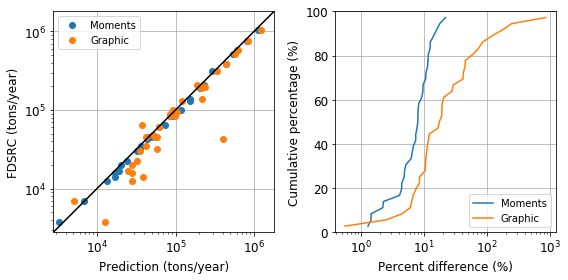

In [16]:
SDcomparison = pd.DataFrame(SDcomparison, columns=['site', 'FDSRC', 'moments', 'graphic', 'ahatg', 'bhatg'
                                                  , 'ahatm', 'bhatm', 'Qmean', 'Qvar']).set_index('site')
print(ccc(SDcomparison['FDSRC'], SDcomparison['moments']))
print(ccc(SDcomparison['FDSRC'], SDcomparison['graphic']))
print(r_squared(SDcomparison['moments'], SDcomparison['FDSRC']))
print(r_squared(SDcomparison['graphic'], SDcomparison['FDSRC']))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.plot(SDcomparison['moments'], SDcomparison['FDSRC'], 'o', label='Moments')
ax1.plot(SDcomparison['graphic'], SDcomparison['FDSRC'], 'o', label='Graphic')
ax1.plot([2780, 1800000], [2780, 1800000], 'k-')
ax1.margins(x=0, y=0)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('FDSRC (tons/year)')
ax1.set_xlabel('Prediction (tons/year)')
ax1.legend()

x1 = (np.abs(SDcomparison['moments'] - SDcomparison['FDSRC'])/SDcomparison['FDSRC']).sort_values()
x2 = (np.abs(SDcomparison['graphic'] - SDcomparison['FDSRC'])/SDcomparison['FDSRC']).sort_values()

y = np.arange(1, SDcomparison.shape[0]+1)/(SDcomparison.shape[0]+1)

ax2.plot(x1*100, y*100, label='Moments')
ax2.plot(x2*100, y*100, label='Graphic')
ax2.set_xlabel('Percent difference (%)')
ax2.set_ylabel('Cumulative percentage (%)')
ax2.set_ylim([0, 100])
ax2.set_xscale('log')
ax2.legend(loc=4)
for ax in [ax1, ax2]:
    ax.grid()
fig.tight_layout()
fig.savefig('moment_vs_graphic.pdf', format='pdf', dpi=500, transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [17]:
SDcomparison

,FDSRC,moments,graphic,ahatg,bhatg,ahatm,bhatm,Qmean,Qvar
site,,,,,,,,,
H1,7.600087e+05,8.109454e+05,8.395293e+05,80.399081,2.310025,183.635765,1.738352,292.557154,379783.784683
H2,1.305446e+05,1.510536e+05,1.209213e+05,1.105192,3.119102,2.489987,2.708576,10.489454,1539.403531
H3,3.175448e+05,2.914826e+05,3.388240e+05,6.428681,3.004704,13.469860,2.567146,48.242508,27423.134259
H4,4.797037e+04,5.179485e+04,5.199289e+04,0.604956,3.148948,1.608060,2.536487,5.564860,351.613049
H5,9.430930e+04,9.885041e+04,1.046234e+05,2.499322,2.826020,4.384052,2.470819,14.110181,2088.444852
H6,1.919495e+05,2.060529e+05,2.143568e+05,71.338176,1.904544,187.868038,1.137720,200.319337,92343.368540
H7,2.982478e+04,3.201842e+04,3.480054e+04,1.445176,3.235412,2.996119,2.716723,12.742613,2294.435213
N10,7.033355e+03,6.747973e+03,5.083201e+03,0.330748,3.135254,0.892786,2.514430,3.014754,100.483006
N11,1.992304e+04,2.036203e+04,2.824579e+04,2.863170,2.940158,5.382793,2.442235,16.793832,2858.399010


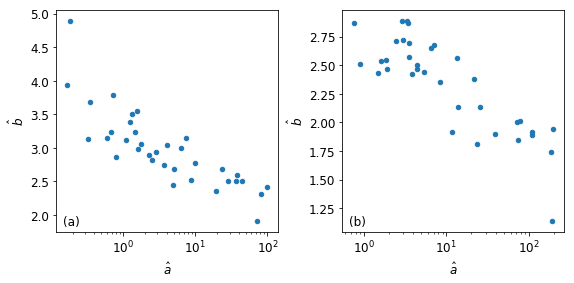

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
SDcomparison.plot.scatter(x='ahatg', y='bhatg', ax=ax1, logx=True)
SDcomparison.plot.scatter(x='ahatm', y='bhatm', ax=ax2, logx=True)
fig.tight_layout()
for ax in [ax1, ax2]:
    ax.set(xlabel='$\hat{a}$', ylabel='$\hat{b}$')

ax1.annotate('(a)', (0.03,0.03), xycoords='axes fraction', fontsize='large')
ax2.annotate('(b)', (0.03,0.03), xycoords='axes fraction', fontsize='large')
fig.savefig('abhat_graphic_moment.pdf', format='pdf', dpi=500, transparent = True, bbox_inches = 'tight', pad_inches = 0.02)

In [19]:
meanAnnualSedDischarge(1.15, 1.44, 4.4, 2.5)

47463.28225656736

In [20]:
SDcomparison['difference'] = np.abs(SDcomparison['graphic'] - SDcomparison['FDSRC']) / SDcomparison['FDSRC']

In [21]:
SDcomparison.sort_values('difference')

,FDSRC,moments,graphic,ahatg,bhatg,ahatm,bhatm,Qmean,Qvar,difference
site,,,,,,,,,,
N9,8.447238e+04,8.992426e+04,8.400549e+04,5.017726,2.679086,8.370848,2.351754,23.709618,5111.605266,0.005527
G1,5.989120e+04,6.124151e+04,6.137210e+04,2.324357,2.891681,4.399673,2.503672,14.681039,2352.154092,0.024727
N8,8.775744e+04,9.872805e+04,8.385924e+04,19.688648,2.351349,38.467793,1.898835,70.222098,26306.268820,0.044420
Y3,9.903980e+04,1.165104e+05,9.307265e+04,4.947987,2.453872,11.839010,1.917640,21.974902,2632.809152,0.060250
N6,4.504354e+04,4.935084e+04,4.219282e+04,28.097151,2.511499,74.220761,1.843834,129.153354,83515.336924,0.063288
H3,3.175448e+05,2.914826e+05,3.388240e+05,6.428681,3.004704,13.469860,2.567146,48.242508,27423.134259,0.067012
H2,1.305446e+05,1.510536e+05,1.209213e+05,1.105192,3.119102,2.489987,2.708576,10.489454,1539.403531,0.073717
H4,4.797037e+04,5.179485e+04,5.199289e+04,0.604956,3.148948,1.608060,2.536487,5.564860,351.613049,0.083854
G2,5.737456e+05,6.017608e+05,6.221197e+05,23.779641,2.690945,70.353900,2.001162,140.858780,119208.665494,0.084313


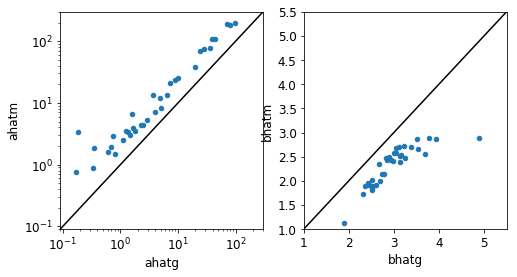

In [99]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

SDcomparison.plot.scatter(x='ahatg', y='ahatm', ax=ax1)
SDcomparison.plot.scatter(x='bhatg', y='bhatm', ax=ax2)

ax1.plot([0.09,300], [0.09, 300], 'k-')
ax1.set(xscale='log', yscale='log')
ax1.margins(x=0, y=0)

ax2.plot([1, 5.5], [1, 5.5], 'k-')
#ax2.set(xscale='log', yscale='log')
ax2.margins(x=0, y=0)

In [22]:
Dmoments = []
Dgraphic = []

for site in stations.keys():
    ahatm, bhatm = method_of_moments(stations[site]['dailyQ']['Q'])
    DQ, DQs, edmQ, edmQs = cdfDiff(stations[site]['dailyQ'], stations[site]['src'], ahatm, bhatm)
    Dmoments.append((site, DQ, DQs, edmQ, edmQs))
    
    ahatg, bhatg = graphical_method(stations[site]['fdc'])
    DQ, DQs, edmQ, edmQs = cdfDiff(stations[site]['dailyQ'], stations[site]['src'], ahatg, bhatg)
    
    Dgraphic.append((site, DQ, DQs, edmQ, edmQs))

In [23]:
def error_cdf(data, var):
    x = data[var].sort_values()
    y = np.arange(1, x.shape[0]+1) / (x.shape[0] + 1)
    return x , y*100

In [24]:
Dmoments = pd.DataFrame(Dmoments).set_index(0)
Dgraphic = pd.DataFrame(Dgraphic).set_index(0)

In [30]:
Dmoments[3].mean()

0.03172815587673535

Text(0.03,0.9,'(b)')

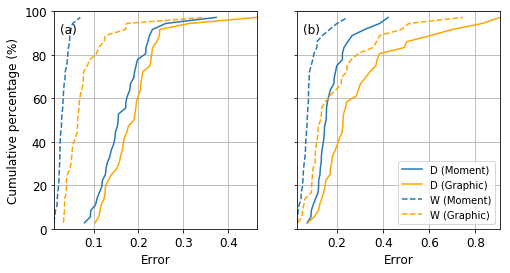

In [106]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), sharey=True)


linestyles= ['-', '-', '--', '--']
labels = ['D (Moment)', 'D (Graphic)', 'W (Moment)', 'W (Graphic)']
for ax, i in zip([ax1, ax2, ax1, ax2], range(1, 5)): 
    x, y = error_cdf(Dmoments, i)
    ax.plot(x, y, label=labels[i-1], linestyle = linestyles[i-1], color='#2578B2')

    x, y = error_cdf(Dgraphic, i)
    ax.plot(x, y, label=labels[i-1], linestyle = linestyles[i-1], color='orange')

ax2.legend(['D (Moment)', 'D (Graphic)', 'W (Moment)', 'W (Graphic)'])
ax1.set_ylabel('Cumulative percentage (%)')
ax1.set_xlabel('Error')
ax2.set_xlabel('Error')


for ax in [ax1, ax2]:
    ax.grid()
    ax.margins(x=0, y=0)
    ax.set_ylim([0, 100])


ax1.annotate('(a)', (0.03,0.9), xycoords='axes fraction', fontsize='large')
ax2.annotate('(b)', (0.03,0.9), xycoords='axes fraction', fontsize='large')

#fig.savefig('./chapter 6/cum_error_graphic_vs_moment.pdf', format='pdf', dpi=500, transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [107]:
attribute = load_attribute()

In [108]:
moments_result = []

for site in stations.keys():
    
    
    area = attribute.loc[site, 'Area']
    Qmean = stations[site]['fdc']['Q'].mean()
    length = stations[site]['fdc'].shape[0]
    
    Qrecord = stations[site]['dailyQ']['Q'].dropna()
    RB = np.sum(np.abs(np.ediff1d(Qrecord)))/np.sum(Qrecord)
    
    ahatm, bhatm = method_of_moments(stations[site]['dailyQ']['Q'])
    abar, bbar = np.e**stations[site]['src'].params[0], stations[site]['src'].params[1]
    
    SDf = FDSRC(stations[site]['fdc'], stations[site]['src'])['QtXD'].sum()*365.25
    
    SDm = meanAnnualSedDischarge(abar, bbar, ahatm, bhatm)
    
    DQ, DQs, edmQ, edmQs = cdfDiff(stations[site]['dailyQ'], stations[site]['src'], ahatm, bhatm)
    moments_result.append((site, length, abar, bbar, ahatm, bhatm, SDm, SDf, DQ, DQs, edmQ, edmQs, area, Qmean, RB))

moments_result = pd.DataFrame(moments_result, columns=['site', 'length', 'abar', 'bbar', 'ahat', 'bhat', 'SDm',
                                                       'SDf', 'DQ', 'DQs', 'edmQ', 'edmQs', 'area', 'Qmean', 'RB']).set_index('site')

In [109]:
moments_result.to_csv('korea_summary.csv')

In [110]:
ssy = moments_result['SDf'] / moments_result['area']
four_param = moments_result['SDm'] / moments_result['area']

In [111]:
rmse(four_param, ssy)

14.771299179711761

In [112]:
mape(four_param, ssy)

0.08236964088243447

In [113]:
ape1 = (np.abs(pred-ssy)/ssy)
x1 = np.sort(ape1)
y1 = np.arange(1, len(x)+1) / len(x1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.plot(pred, ssy, 'o')
ax1.plot([3.5, 600], [3.5, 600], 'k-')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.plot(x1*100, y1*100)
ax1.set_xlabel('Measured (tons/km$^2\cdot$year)')
ax1.set_ylabel('Predicted (tons/km$^2\cdot$year)')
ax2.set_xlabel('Error (%)')
ax2.set_ylabel('Percentage (%)')
for ax in [ax1, ax2]:
    ax.margins(x=0, y=0)
    ax.grid()
fig.tight_layout()

NameError: name 'pred' is not defined

In [114]:
model_a = trainLinear(moments_result['area'].drop(['H6', 'N13']), moments_result['ahat'].drop(['H6', 'N13']))
model_b = trainLinear(moments_result['area'].drop(['H6', 'N13']), np.e**moments_result['bhat'].drop(['H6', 'N13']))

src_remove = ['G5', 'S4', 'N10', 'N13', 'G3', 'N8']
model_c = trainLinear(moments_result['area'].drop(src_remove), moments_result['abar'].drop(src_remove))
model_d = trainLinear(moments_result['area'].drop(src_remove), np.e**moments_result['bbar'].drop(src_remove))

In [115]:
pred_a = np.e**use(moments_result['area'], model_a)
pred_b = use(moments_result['area'], model_b)
pred_c = np.e**use(moments_result['area'], model_c)
pred_d = use(moments_result['area'], model_d)

In [116]:
one_param = meanAnnualSedDischarge(pred_c, pred_d, pred_a, pred_b) / moments_result['area']

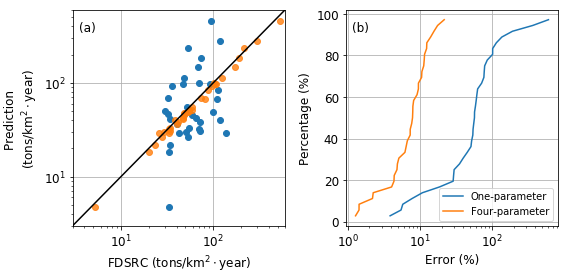

In [117]:
ape2 = (np.abs(one_param-ssy)/ssy)
x2 = np.sort(ape2)
y2 = np.arange(1, len(x2)+1) / (len(x2)+1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.plot(one_param, ssy, 'o', label='One-parameter model')
ax1.plot(moments_result['SDm']/moments_result['area'], ssy, 'o', alpha=0.8, label='Four-parameter model')
ax1.plot([3, 600], [3, 600], 'k-')
ax1.set_xscale('log')
ax1.set_yscale('log')

x1 =  (np.abs(moments_result['SDm']/moments_result['area'] - moments_result['SDf']/moments_result['area'])/(moments_result['SDf']/moments_result['area'])).sort_values()
y1 = np.arange(1, SDcomparison.shape[0]+1)/(SDcomparison.shape[0]+1)
ax2.plot(x2*100, y2*100, label='One-parameter')
ax2.plot(x1*100, y1*100, label='Four-parameter')

ax1.set_xlabel('FDSRC (tons/km$^2\cdot$year)')
ax1.set_ylabel('Prediction \n(tons/km$^2\cdot$year)')
ax2.set_xlabel('Error (%)')
ax2.set_ylabel('Percentage (%)')
ax2.set_xscale('log')
ax2.legend()

ax1.margins(x=0, y=0)
for ax in [ax1, ax2]:
    ax.grid()
fig.tight_layout()
ax1.annotate('(a)', (0.03,0.9), xycoords='axes fraction', fontsize='large')
ax2.annotate('(b)', (0.03,0.9), xycoords='axes fraction', fontsize='large')
fig.savefig('./chapter 6/four_parameter_performace.pdf', format='pdf', dpi=500, bbox_inches='tight')

In [39]:
rmse(ssy, one_param)

85.07460937820932

In [41]:
mape(ssy, one_param)

0.7533385203827441

# Validation

In [42]:
station_name_covert = {u'옥천': 'GU1', u'내린천':'HU7', u'달천':'HU4', u'삼옥교':'HU2',
                      u'북천':'HU6', u'영월1': 'HU3', u'원통':'HU8', u'매일':'HU5', u'영춘':'HU1',
                      u'고현':'NU10', u'양삼':'NU2', u'거창1':'NU6', u'산청':'NU13', u'대리': 'NU11',
                      u'영양': 'NU3', u'거창2': 'NU7', u'창촌':'NU12', u'동천':'NU4', u'소천':'NU1',
                      u'청송': 'NU5', u'지산':'NU8', u'태수':'NU14', u'동곡2':'NU9', u'임천':'NU15',
                      u'외송':'NU16', u'천천':'GU4', u'청성':'GU2', u'동향':'GU5', u'호찬':'GU3',
                      u'송전':'SU5', u'겸백':'SU3', u'관촌':'SU1', u'봉덕':'YU1', u'쌍치2':'SU2',
                      u'장전2':'SU4'}


df = pd.read_excel('./data/validationdata/newdataset_attribute.xlsx', skiprows=4, header=None)
df = df.transpose()
df = df.drop(df.columns[[1,2]], axis=1)
df.columns = ['Name', 'Area','Avg_slope', 'Main_length',
            'Tributary_length', 'Total_length', 'Density', 'clay50', 'silt50','sand50','Urban','Agriculture','Forest',
            'Pasture','Wetland','Bare_land','Water']
df.drop([0,1,2], inplace=True)
df['Name'] = df['Name'].replace(station_name_covert)
df.set_index('Name', inplace=True)
attribute = attribute.append(df)

In [43]:
def findSedimentFiles():
    """Load all excel files in folders"""
    pathes = []
    for root, dirs, files in os.walk("."):
        for file in files:
            if file.endswith(".xlsx"):
                if file.startswith("K-water"):
                    path = root + "/" + file
                    pathes.append(path)
    return pathes

In [44]:
sediments = findSedimentFiles()

In [45]:
vstations = {}

for sediment in sediments:
    df = pd.read_excel(sediment, skiprows=4, usecols=[4,5,11,16,17,20], 
                       names=['site', 'date','Q', 'C', 'Qs', 'Qt'], converters={})
    df.drop(df[df['site'] == '관측소명\nFlow and sediment station'].index, inplace=True)
    #df = df.dropna(subset = ['측정년.월.일.시\nDate'])
    df['site'] = df['site'].fillna(method='ffill')

    df['site'] = [station_name_covert[n] for n in df['site']]
    df['Q'] = pd.to_numeric(df['Q'], errors='coerce')
    df['C'] = pd.to_numeric(df['C'], errors='coerce')
    df['Qs'] = pd.to_numeric(df['Qs'], errors='coerce')
    df['Qt'] = pd.to_numeric(df['Qt'], errors='coerce')
    df = df.dropna(subset=['site', 'Q'])
    df.date = df.date.astype(str)
    df.date = pd.to_datetime(df.date.str[:10])



    UniqueNames = df.site.unique()
    DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
    for key in DataFrameDict.keys():
        DataFrameDict[key] = {'sediment':df[['date', 'Q', 'C', 'Qs', 'Qt']][df.site == key]}

    vstations.update(DataFrameDict)

In [46]:
for site in vstations.keys():
    df = vstations[site]['sediment'].copy()
    df = df.dropna(subset=['Q', 'Qs'])

    try:
        src = trainLinear(df['Q'], df['Qs'])
        vstations[site].update({'src':src})
    except:
        pass

/Users/chunyao/Dropbox/work/dissertation/linearregression.py:21: RuntimeWarning: divide by zero encountered in log
  model = sm.OLS(np.log(T),X).fit()


In [47]:
vQ = ['NU1_Watershed_QH.xls', 'NU13_Watershed_QH.xls', 'GU4_Watershed_QH.xls', 'GU2_Watershed_QH.xls']
folder = './data/validationdata/discharge/'

for f in vQ:
    df = pd.read_excel(folder+f,header=None, usecols=range(30))
    if df.as_matrix().shape[1] < 30:
        df[30] = np.nan
    df = pd.DataFrame(df.as_matrix().reshape(3660, 3), columns=['date', 'h', 'Q']).sort_values(by='date').dropna(subset=['date'])
    df.columns = ['date', 'h', 'Q']
    df.index = pd.date_range('2006','2015-12-31')
    df.drop(['date', 'h'] , axis=1, inplace=True)
    
    site = f[:f.find('_')]
    vstations[site].update({'dailyQ':df, 'fdc':flowDuration(df.reset_index().rename(columns={'index':'date'}))})

In [58]:
vresult = []

for site in ['NU1', 'NU13', 'GU4', 'GU2']:
    SDf = FDSRC(vstations[site]['fdc'], vstations[site]['src'])['QtXD'].sum() * 365.25 / attribute.loc[site, 'Area']
    ahat, bhat = method_of_moments(vstations[site]['dailyQ'])
    abar, bbar = np.e**vstations[site]['src'].params[0], vstations[site]['src'].params[1]
    SDm = meanAnnualSedDischarge(abar, bbar, ahat, bhat) / attribute.loc[site, 'Area']
    vresult.append((site, attribute.loc[site, 'Area'], ahat, bhat, abar, bbar, SDf, SDm))

vresult = pd.DataFrame(vresult, columns=['site', 'area', 'ahat', 'bhat', 'abar', 'bbar', 'SDf', 'SDm']).set_index('site')

In [59]:
one_model_a = np.e**use(attribute.loc[['NU1', 'NU13', 'GU4', 'GU2'], 'Area'].values.astype(float) , model_a)
one_model_b = use(attribute.loc[['NU1', 'NU13', 'GU4', 'GU2'], 'Area'].values.astype(float) , model_b)
one_model_c = np.e**use(attribute.loc[['NU1', 'NU13', 'GU4', 'GU2'], 'Area'].values.astype(float) , model_c)
one_model_d = use(attribute.loc[['NU1', 'NU13', 'GU4', 'GU2'], 'Area'].values.astype(float) , model_d)



vresult['SDone'] = meanAnnualSedDischarge(one_model_c, one_model_d, one_model_a, one_model_b) / attribute.loc[['NU1', 'NU13', 'GU4', 'GU2'], 'Area'].values.astype(float)


In [68]:
vresult.to_clipboard()

In [163]:
print(rmse(vresult['SDm'], vresult['SDf']))
print(mape(vresult['SDm'], vresult['SDf']))
print(ccc(vresult['SDm'], vresult['SDf']))
print(r_squared(vresult['SDm'], vresult['SDf']))

3.8572948483375544
0.06873659188424369
0.8081098996503071
0.9148443373682573


In [166]:
print(rmse(vresult['SDone'], vresult['SDf']))
print(mape(vresult['SDone'], vresult['SDf']))
print(ccc(vresult['SDone'], vresult['SDf']))
print(r_squared(vresult['SDone'], vresult['SDf']))

32.24509337122555
0.6477928965541384
-0.04885534569127188
-0.2812208683138365


Text(0,0.5,'Prediction (tons/km$^2\\cdot$year)')

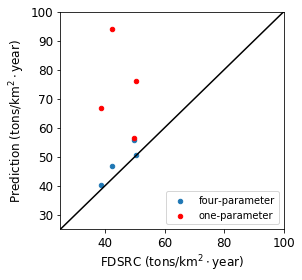

In [62]:
fig, ax = plt.subplots(figsize=(4,4))
vresult.plot.scatter(x='SDf', y='SDm', ax=ax, label='four-parameter')
vresult.plot.scatter(x='SDf', y='SDone', ax=ax, color='r', label='one-parameter')
ax.plot([25, 100], [25, 100], 'k-')
ax.margins(x=0,y=0)
ax.set_xlabel('FDSRC (tons/km$^2\cdot$year)')
ax.set_ylabel('Prediction (tons/km$^2\cdot$year)')

In [69]:
vDiff = []

for site in ['NU1', 'NU13', 'GU4', 'GU2']:
    vDiff.append(cdfDiff(vstations[site]['dailyQ'], vstations[site]['src'], 
                         vresult.loc[site, 'ahat'], vresult.loc[site, 'bhat']))
vDiff = pd.DataFrame(vDiff, columns=['DQ', 'DQs', 'WQ', 'WQs'])
vDiff.index = ['NU1', 'NU13', 'GU4', 'GU2']
vDiff.to_clipboard()